In [1]:
import sys
root_dir_abspath = '/home/adnen.boumessouer/LEGO-Anomaly-Detection'

In [2]:
sys.path.insert(0, root_dir_abspath)

In [3]:
import os
from pathlib import Path

import tensorflow as tf
# import skimage
from skimage.util import img_as_ubyte

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import argparse
import time

from processing.preprocessing import Preprocessor
from processing.preprocessing import get_preprocessing_function
from processing import utils
from processing import postprocessing

from processing.postprocessing import calculate_resmaps

# Load CAE

In [4]:
model_path ="saved_models/LEGO_light/SV/resnetCAE/mssim/18-09-2020_09-13-09/resnetCAE_b8_e93.hdf5"

In [5]:
# load model and info
model, info, _ = utils.load_model_HDF5(model_path)

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


In [6]:
# set parameters
input_directory = info["data"]["input_directory"]
architecture = info["model"]["architecture"]
loss = info["model"]["loss"]
rescale = info["preprocessing"]["rescale"]
shape = info["preprocessing"]["shape"]
color_mode = info["preprocessing"]["color_mode"]
vmin = info["preprocessing"]["vmin"]
vmax = info["preprocessing"]["vmax"]
nb_validation_images = info["data"]["nb_validation_images"]

In [7]:
# get the correct preprocessing function
preprocessing_function = info["preprocessing"]["preprocessing"]

# Compute Reconstructions

In [45]:
def compare_input_pred_resmap(imgs_input, imgs_pred, indicies=None, threshold=None):
    # if Grayscale
    if imgs_input.shape[-1] == 1:
        imgs_input = imgs_input[:, :, :, 0]
        imgs_pred = imgs_pred[:, :, :, 0]
        cmap = "gray"
    # if RGB
    else:
        cmap = None

    scores, resmaps = calculate_resmaps(imgs_input, imgs_pred, method="ssim")

    if indicies is None:
        nrows = imgs_input.shape[0]       
        indicies = list(range(nrows))
    else:
        nrows = len(indicies)
        
    fig, axarr = plt.subplots(nrows=nrows, ncols=3, figsize=(15, 5*nrows))
    
    for i,j in enumerate(indicies):
        axarr[i,0].imshow(imgs_input[j], cmap=cmap)
        axarr[i,0].set_title("input")
        axarr[i,0].set_axis_off()
        
        axarr[i,1].imshow(imgs_pred[j], cmap=cmap)
        axarr[i,1].set_title("pred")
        axarr[i,1].set_axis_off()
        
        res = axarr[i,2].imshow(resmaps[j], vmin=0.0, vmax=1.0, cmap="inferno")
        axarr[i,2].set_title("resmap")
        axarr[i,2].set_axis_off()
        fig.colorbar(res, ax=axarr[i,2])
    return fig

In [17]:
def get_indicies(list_tuple):
    return [elem[0] for elem in list_tuple]

## Validation Images

In [9]:
# initialize preprocessor
preprocessor = Preprocessor(
    input_directory=input_directory,
    rescale=rescale,
    shape=shape,
    color_mode=color_mode,
    preprocessing_function=preprocessing_function,)

In [10]:
# get validation generator
validation_generator = preprocessor.get_val_generator(
    batch_size=nb_validation_images, shuffle=True)

Found 28 images belonging to 1 classes.


In [11]:
# retrieve validation images from generator
imgs_val_input = validation_generator.next()[0]

In [12]:
# display shape
imgs_val_input.shape

(28, 256, 256, 3)

In [13]:
# retrieve validation image names
filenames_val = validation_generator.filenames

In [14]:
list(enumerate(filenames_val))

[(0, 'A_good_sv/001.png'),
 (1, 'A_good_sv/002.png'),
 (2, 'A_good_sv/003.png'),
 (3, 'A_good_sv/004.png'),
 (4, 'A_good_sv/006.png'),
 (5, 'A_good_sv/007.png'),
 (6, 'A_good_sv/008.png'),
 (7, 'A_good_sv/009.png'),
 (8, 'A_good_sv/011.png'),
 (9, 'A_good_sv/012.png'),
 (10, 'A_good_sv/013.png'),
 (11, 'A_good_sv/014.png'),
 (12, 'A_good_sv/016.png'),
 (13, 'A_good_sv/017.png'),
 (14, 'A_good_sv/018.png'),
 (15, 'A_good_sv/019.png'),
 (16, 'A_good_sv/021.png'),
 (17, 'A_good_sv/022.png'),
 (18, 'A_good_sv/023.png'),
 (19, 'A_good_sv/024.png'),
 (20, 'A_good_sv/026.png'),
 (21, 'A_good_sv/027.png'),
 (22, 'A_good_sv/028.png'),
 (23, 'A_good_sv/029.png'),
 (24, 'A_good_sv/031.png'),
 (25, 'A_good_sv/032.png'),
 (26, 'A_good_sv/033.png'),
 (27, 'A_good_sv/034.png')]

In [15]:
# get reconstructed images (i.e predictions) on validation dataset
imgs_val_pred = model.predict(imgs_val_input, verbose=1)

28/28 [==============================] - 5s 166ms/sample


In [16]:
# display shape
imgs_val_pred.shape

(28, 256, 256, 3)

## Plot Original, Reconstructed and Resmap Images (VALIDATION)

In [59]:
list_A_good_sv = [
    (0, 'A_good_sv/001.png'),
    (10, 'A_good_sv/013.png'),
    (20, 'A_good_sv/026.png'),
    (23, 'A_good_sv/029.png'),
    (27, 'A_good_sv/034.png'),
    ]

In [60]:
list_A_good_sv_i = get_indicies(list_A_good_sv)

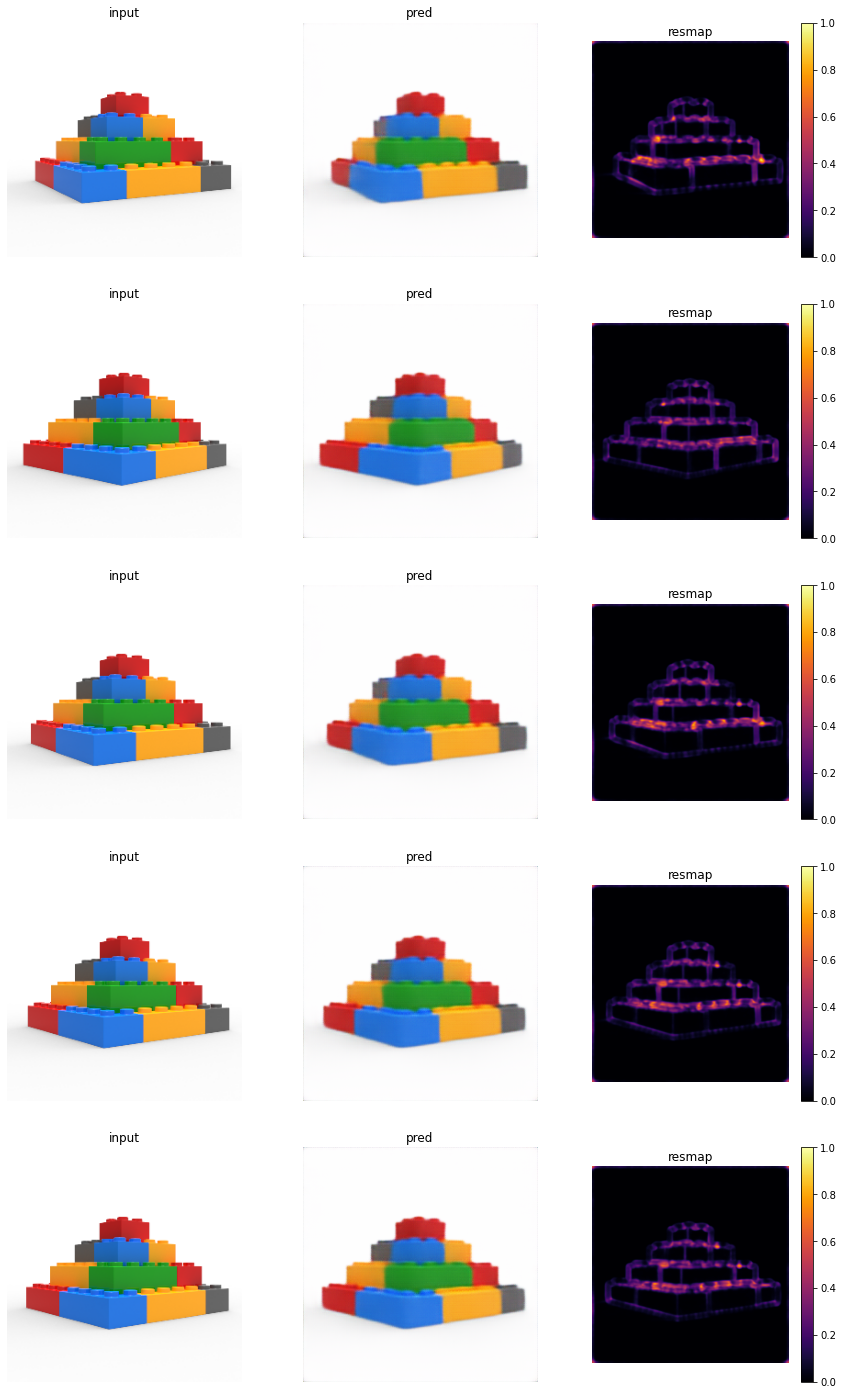

In [46]:
fig1 = compare_input_pred_resmap(imgs_val_input, imgs_val_pred, list_A_good_sv_i)

In [47]:
fig1.savefig(os.path.join(root_dir_abspath, "val_trio.png"))

## Test Images

In [22]:
# get test generator
nb_test_images = preprocessor.get_total_number_test_images()
test_generator = preprocessor.get_test_generator(batch_size=nb_test_images, shuffle=False)

Found 497 images belonging to 7 classes.


In [23]:
# retrieve validation images from generator
imgs_test_input = test_generator.next()[0]

In [24]:
# display shape
imgs_test_input.shape

(497, 256, 256, 3)

In [25]:
# retrieve test image names
filenames_test = test_generator.filenames

In [26]:
list(enumerate(filenames_test))

[(0, 'A_good_sv/005.png'),
 (1, 'A_good_sv/010.png'),
 (2, 'A_good_sv/015.png'),
 (3, 'A_good_sv/020.png'),
 (4, 'A_good_sv/025.png'),
 (5, 'A_good_sv/030.png'),
 (6, 'A_good_sv/035.png'),
 (7, 'A_good_sv/040.png'),
 (8, 'A_good_sv/045.png'),
 (9, 'A_good_sv/050.png'),
 (10, 'A_good_sv/055.png'),
 (11, 'A_good_sv/060.png'),
 (12, 'A_good_sv/065.png'),
 (13, 'A_good_sv/070.png'),
 (14, 'A_good_sv/075.png'),
 (15, 'A_good_sv/080.png'),
 (16, 'A_good_sv/085.png'),
 (17, 'A_good_sv/090.png'),
 (18, 'A_good_sv/095.png'),
 (19, 'A_good_sv/100.png'),
 (20, 'A_good_sv/105.png'),
 (21, 'A_good_sv/110.png'),
 (22, 'A_good_sv/115.png'),
 (23, 'A_good_sv/120.png'),
 (24, 'A_good_sv/125.png'),
 (25, 'A_good_sv/130.png'),
 (26, 'A_good_sv/135.png'),
 (27, 'A_good_sv/140.png'),
 (28, 'A_good_sv/145.png'),
 (29, 'A_good_sv/150.png'),
 (30, 'A_good_sv/155.png'),
 (31, 'A_good_sv/160.png'),
 (32, 'A_good_sv/165.png'),
 (33, 'A_good_sv/170.png'),
 (34, 'A_good_sv/175.png'),
 (35, 'A_good_sv/180.png'),
 (

In [27]:
# get reconstructed images (i.e predictions) on test dataset
imgs_test_pred = model.predict(imgs_test_input, verbose=1)

497/497 [==============================] - 6s 12ms/sample


In [28]:
# display shape
imgs_test_pred.shape

(497, 256, 256, 3)

## Plot Original, Reconstructed and Resmap Images (TEST)

In [72]:
list_A_test_good_sv = [
    (1, 'A_good_sv/010.png'),
    (10, 'A_good_sv/055.png'),
    (15, 'A_good_sv/080.png'),
    (23, 'A_good_sv/120.png'),
    (47, 'A_good_sv/240.png'),   
]

In [73]:
list_B_added_sv = [
    (73, 'B_added_sv/020.png'),
    (75, 'B_added_sv/040.png'),
    (79, 'B_added_sv/080.png'),
    (80, 'B_added_sv/090.png'),
    (83, 'B_added_sv/120.png'),
    (87, 'B_added_sv/230.png'),    
]

In [74]:
list_B_missing_sv = [
    (110, 'B_missing_sv/010.png'),
    (120, 'B_missing_sv/020.png'),
    (130, 'B_missing_sv/030.png'),
    (140, 'B_missing_sv/040.png'),
    (180, 'B_missing_sv/080.png'),
    (200, 'B_missing_sv/100.png'),
    (210, 'B_missing_sv/110.png'),
    (252, 'B_missing_sv/260.png'),
    (262, 'B_missing_sv/270.png'),
    (312, 'B_missing_sv/320.png'),
]

In [75]:
list_B_shifted_sv = [
    (353, 'B_shifted_sv/010.png'),
    (355, 'B_shifted_sv/030.png'),
    (356, 'B_shifted_sv/040.png'),
    (362, 'B_shifted_sv/100.png'),
    (372, 'B_shifted_sv/200.png'),
    (375, 'B_shifted_sv/230.png'),
]

In [76]:
list_C_color_1_sv = [
    (390, 'C_color_1_sv/020.png'),
    (393, 'C_color_1_sv/050.png'),
    (399, 'C_color_1_sv/110.png'),
]

In [77]:
list_C_color_2_sv = [
    (425, 'C_color_2_sv/010.png'),
    (427, 'C_color_2_sv/030.png'),
    (432, 'C_color_2_sv/080.png'),
]

In [78]:
list_C_color_3_sv = [
    (461, 'C_color_3_sv/001.png'),
    (462, 'C_color_3_sv/010.png'),
    (478, 'C_color_3_sv/180.png'),
]

In [79]:
list_A_test_good_sv_i = get_indicies(list_A_test_good_sv)
list_B_added_sv_i = get_indicies(list_B_added_sv)
list_B_missing_sv_i = get_indicies(list_B_missing_sv)
list_B_shifted_sv_i = get_indicies(list_B_shifted_sv)
list_C_color_1_sv_i = get_indicies(list_C_color_1_sv)
list_C_color_2_sv_i = get_indicies(list_C_color_2_sv)
list_C_color_3_sv_i = get_indicies(list_C_color_3_sv)

In [85]:
list_A_test_good_sv_i

[1, 10, 15, 23, 47]

In [81]:
FILENAMES_TEST_INSPECTION = [
    'A_good_sv/010.png',
    'A_good_sv/055.png',
    'A_good_sv/080.png',
    'A_good_sv/120.png',
    'A_good_sv/240.png',
    "B_added_sv/020.png",
    "B_added_sv/040.png",
    "B_added_sv/080.png",
    "B_added_sv/090.png",
    "B_added_sv/120.png",
    "B_added_sv/230.png",
    "B_missing_sv/010.png",
    "B_missing_sv/020.png",
    "B_missing_sv/030.png",
    "B_missing_sv/040.png",
    "B_missing_sv/080.png",
    "B_missing_sv/100.png",
    "B_missing_sv/110.png",
    "B_missing_sv/260.png",
    "B_missing_sv/270.png",
    "B_missing_sv/320.png",
    "B_shifted_sv/010.png",
    "B_shifted_sv/030.png",
    "B_shifted_sv/040.png",
    "B_shifted_sv/100.png",
    "B_shifted_sv/200.png",
    "B_shifted_sv/230.png",
    "C_color_1_sv/020.png",
    "C_color_1_sv/050.png",
    "C_color_1_sv/110.png",
    "C_color_2_sv/010.png",
    "C_color_2_sv/030.png",
    "C_color_2_sv/080.png",
    "C_color_3_sv/001.png",
    "C_color_3_sv/010.png",
    "C_color_3_sv/180.png",
]

In [82]:
indicies = [filenames_test.index(filename) for filename in FILENAMES_TEST_INSPECTION]

In [83]:
indicies

[1,
 10,
 15,
 23,
 47,
 73,
 75,
 79,
 80,
 83,
 87,
 110,
 120,
 130,
 140,
 180,
 200,
 210,
 252,
 262,
 312,
 353,
 355,
 356,
 362,
 372,
 375,
 390,
 393,
 399,
 425,
 427,
 432,
 461,
 462,
 478]

### Anomaly-Free Test Images

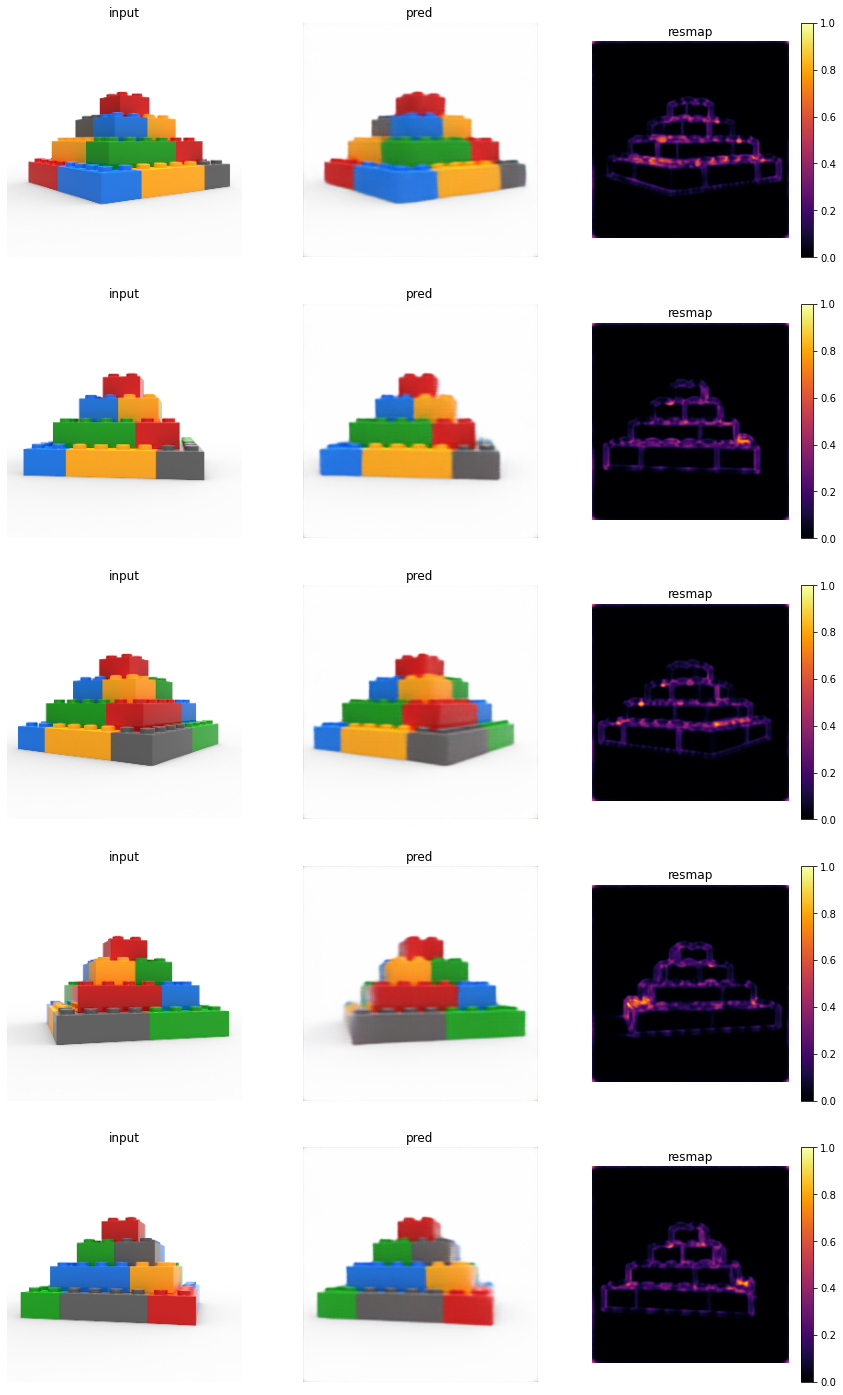

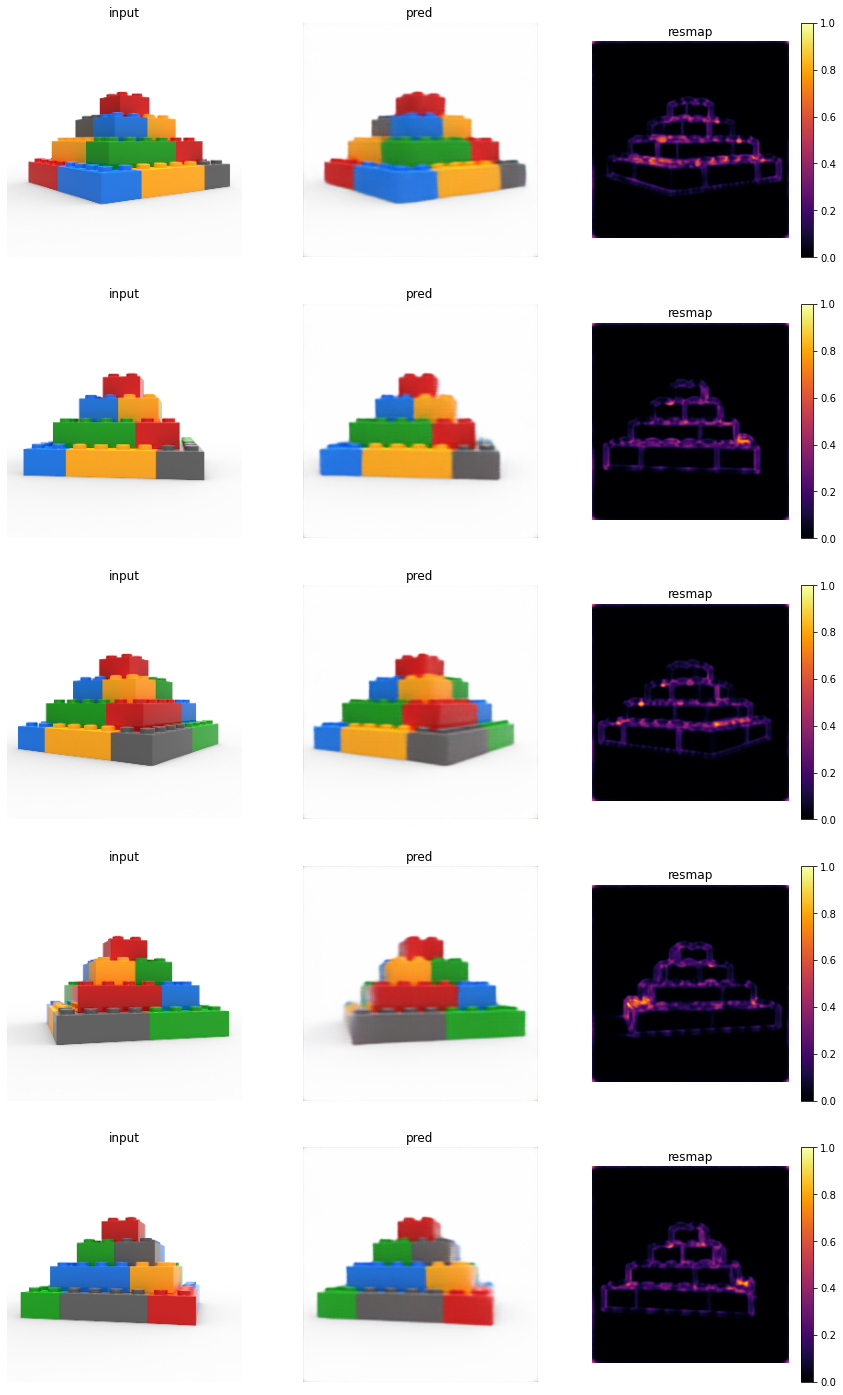

In [84]:
compare_input_pred_resmap(imgs_test_input, imgs_test_pred, list_A_test_good_sv_i)

### Anomaly type: added Lego-Brick

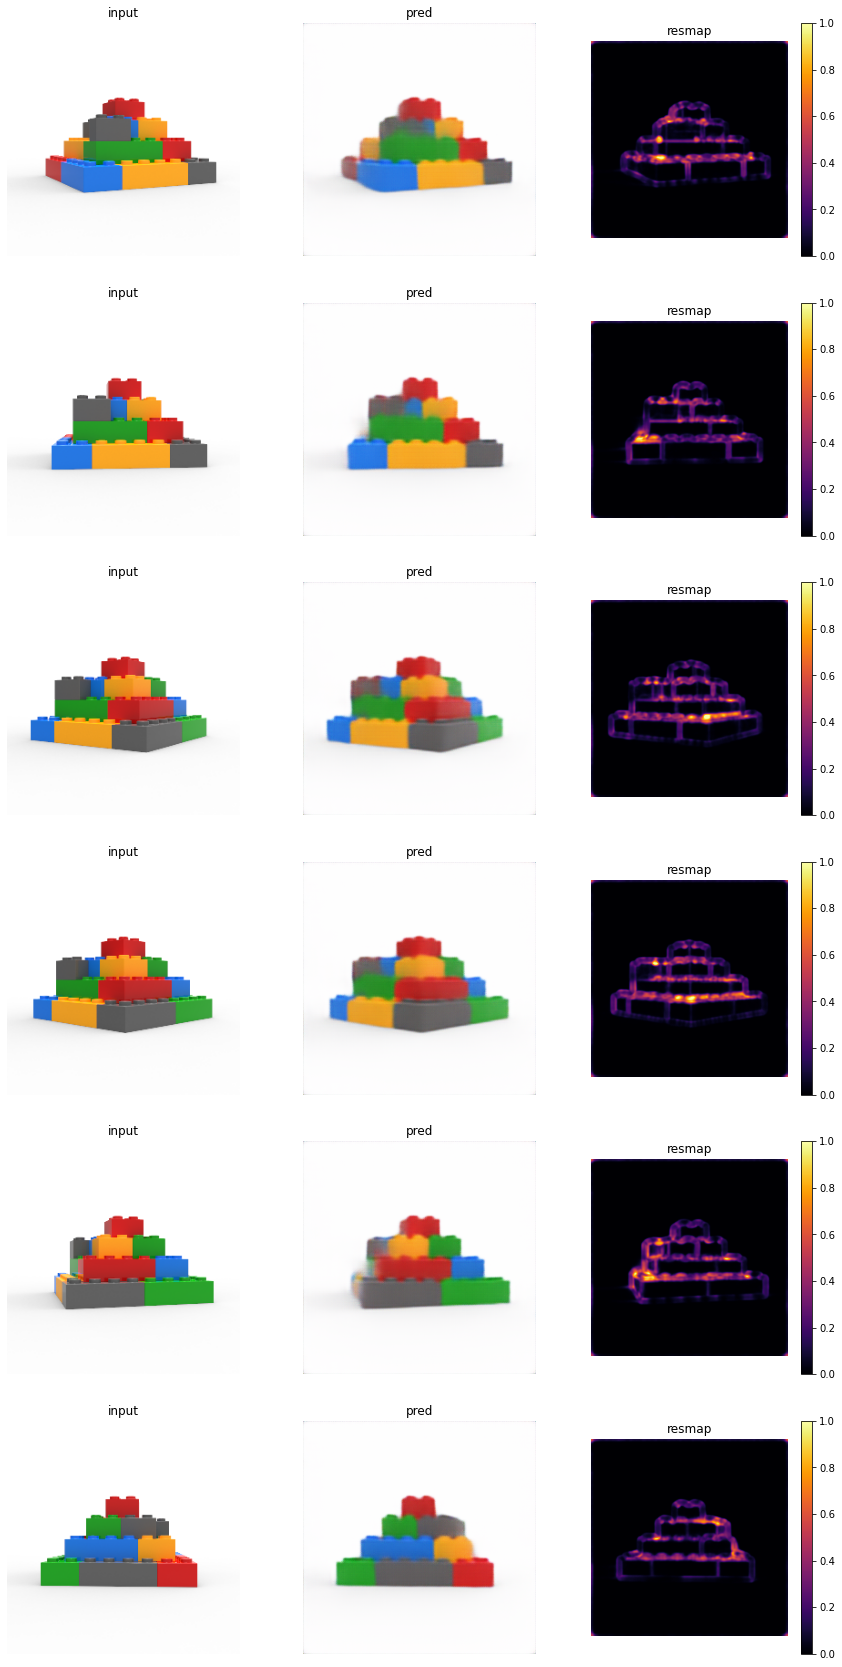

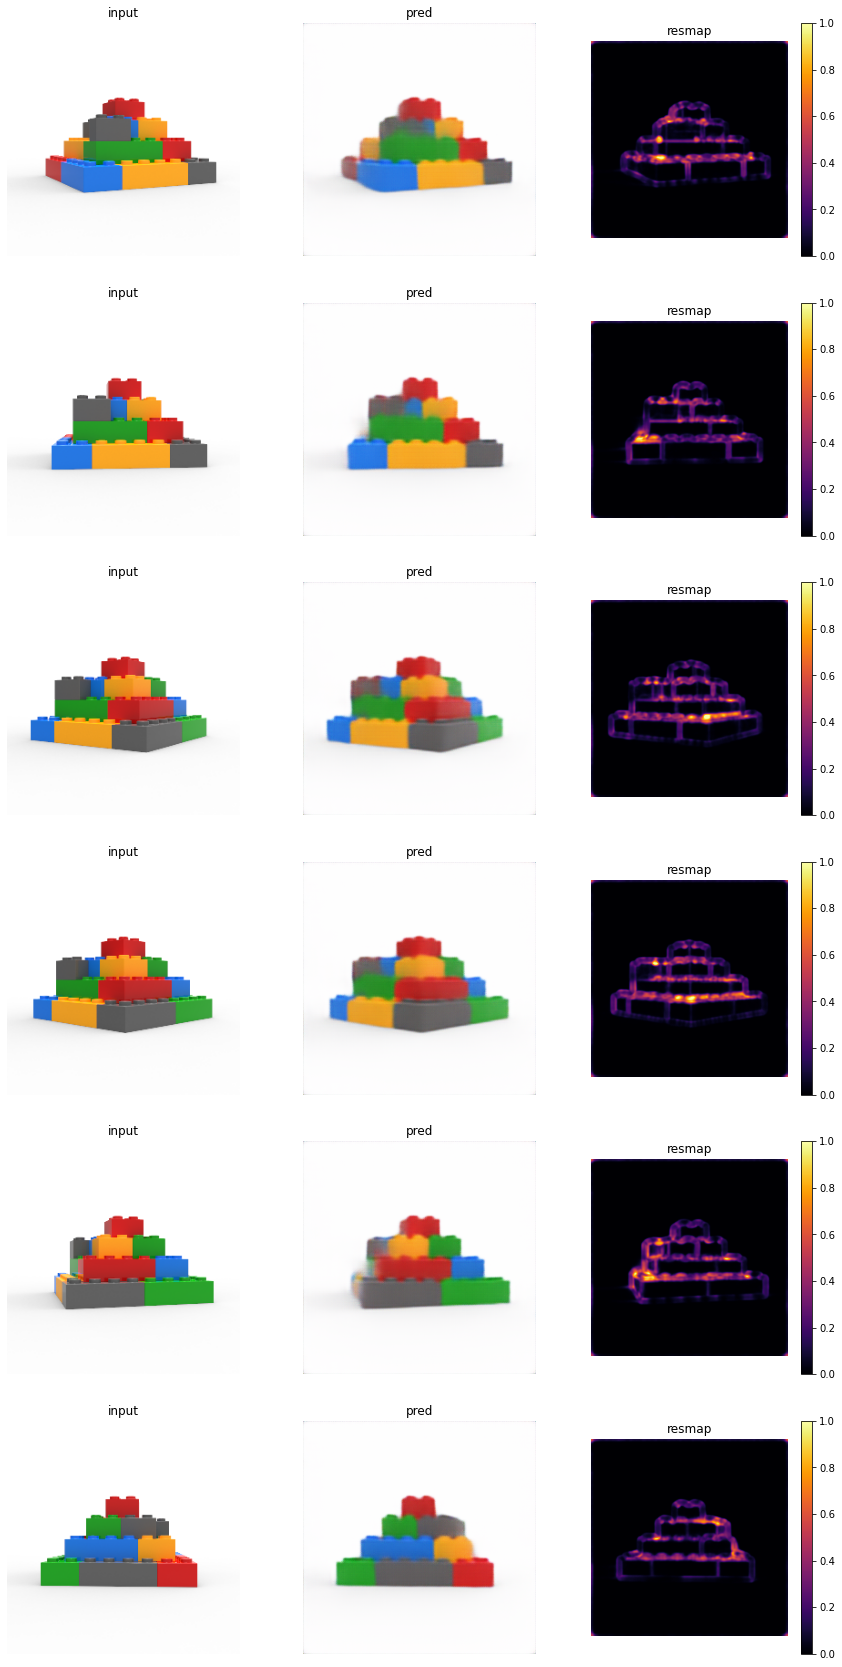

In [68]:
compare_input_pred_resmap(imgs_test_input, imgs_test_pred, list_B_added_sv_i)

### Anomaly type: missing Lego-Brick

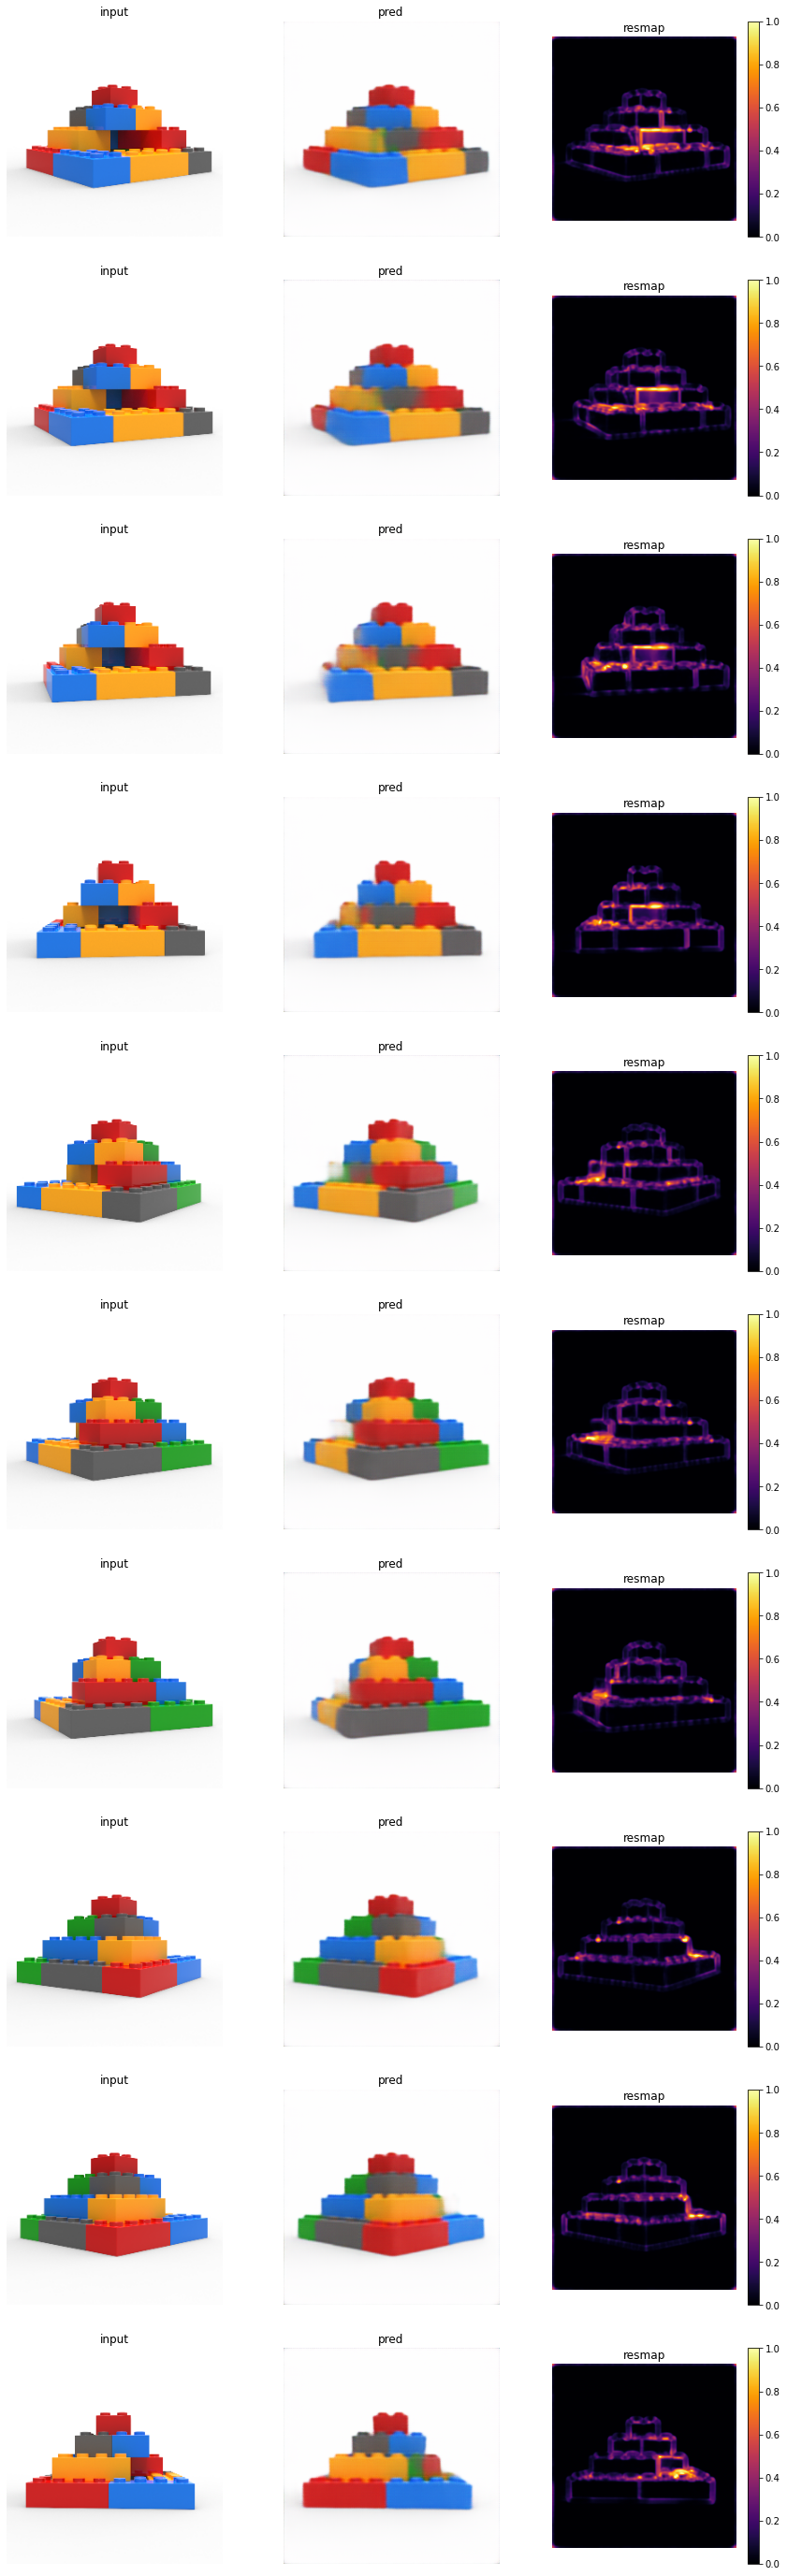

In [40]:
compare_input_pred_resmap(imgs_test_input, imgs_test_pred, list_B_missing_sv_i)

### Anomaly type: shifted Lego-Brick

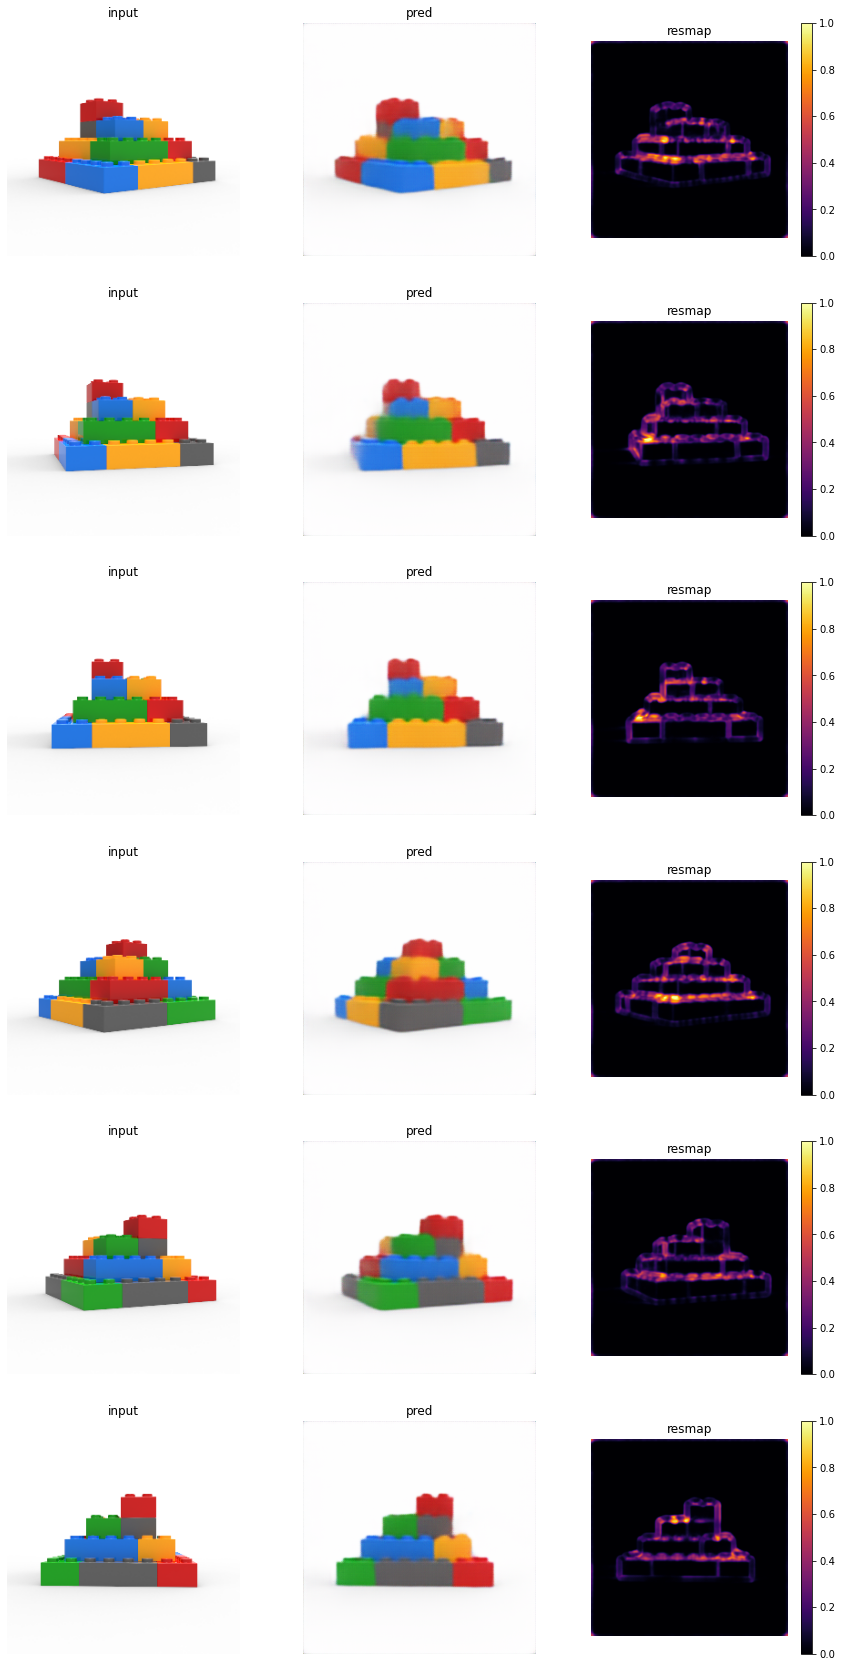

In [41]:
compare_input_pred_resmap(imgs_test_input, imgs_test_pred, list_B_shifted_sv_i)

### Anomaly type: false color 1 Lego-Brick

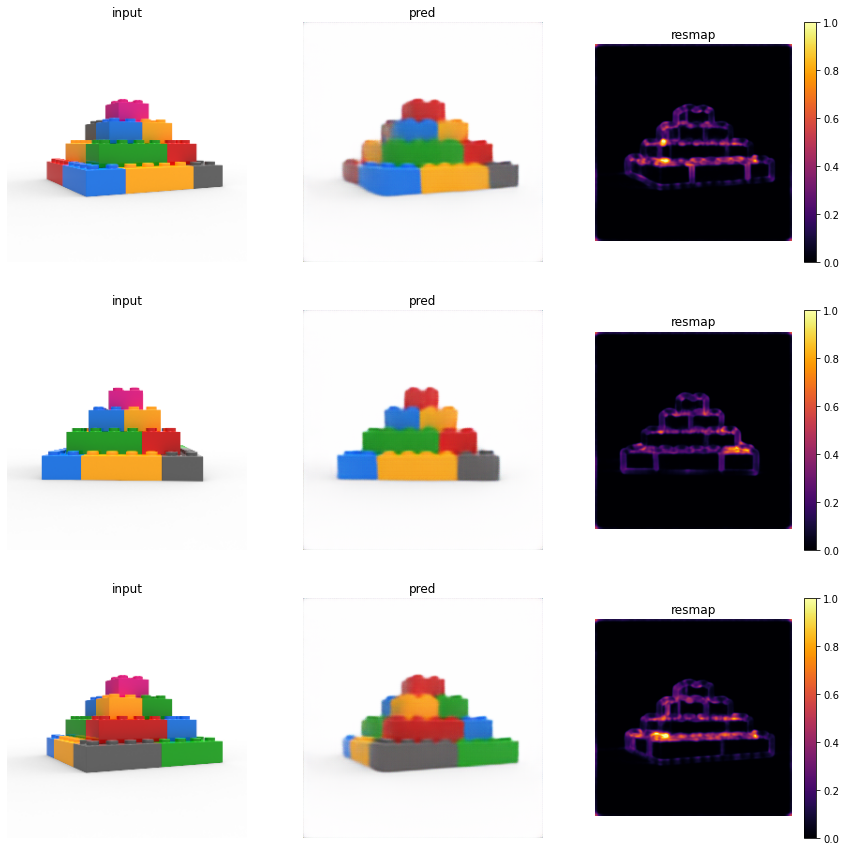

In [42]:
compare_input_pred_resmap(imgs_test_input, imgs_test_pred, list_C_color_1_sv_i)

### Anomaly type: false color 2 Lego-Brick

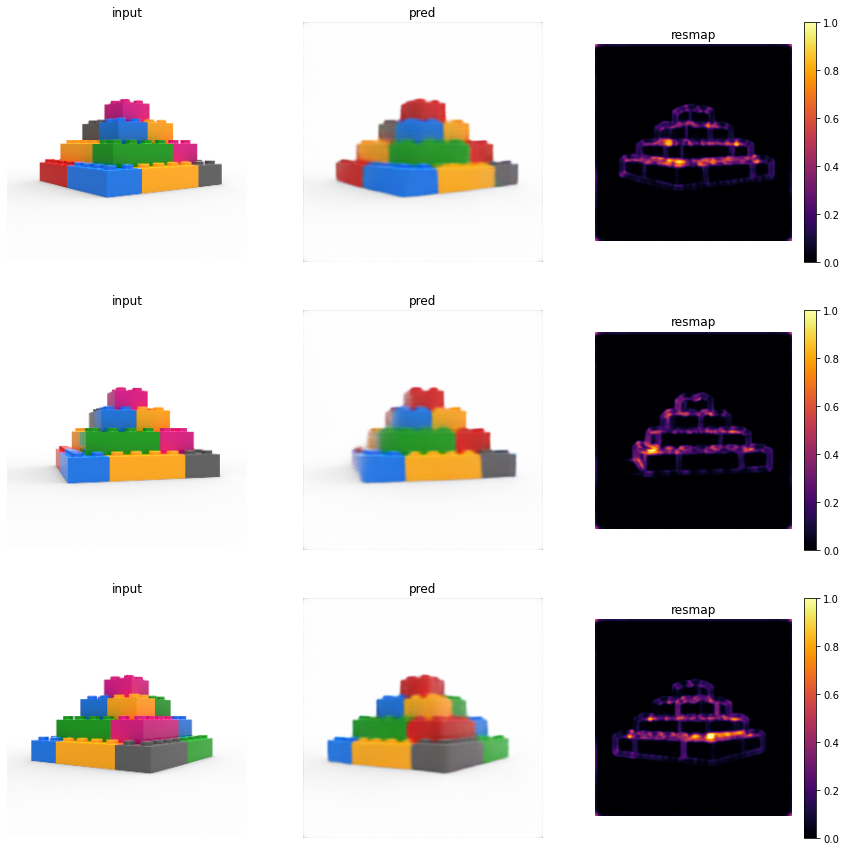

In [43]:
compare_input_pred_resmap(imgs_test_input, imgs_test_pred, list_C_color_2_sv_i)

### Anomaly type: false color 3 Lego-Brick

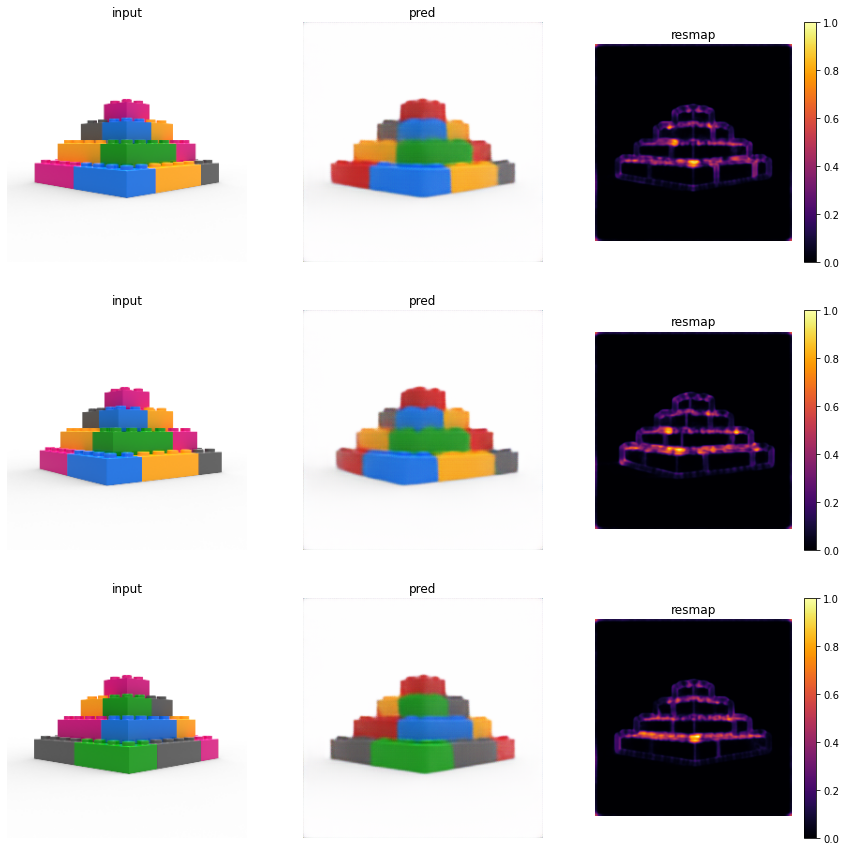

In [44]:
compare_input_pred_resmap(imgs_test_input, imgs_test_pred, list_C_color_3_sv_i)

In [85]:
test_generator.filepaths

['LEGO_light/SV/test/B_added_sv/B_added_sv_010.png',
 'LEGO_light/SV/test/B_added_sv/B_added_sv_020.png',
 'LEGO_light/SV/test/B_added_sv/B_added_sv_030.png',
 'LEGO_light/SV/test/B_added_sv/B_added_sv_040.png',
 'LEGO_light/SV/test/B_added_sv/B_added_sv_050.png',
 'LEGO_light/SV/test/B_added_sv/B_added_sv_060.png',
 'LEGO_light/SV/test/B_added_sv/B_added_sv_070.png',
 'LEGO_light/SV/test/B_added_sv/B_added_sv_080.png',
 'LEGO_light/SV/test/B_added_sv/B_added_sv_090.png',
 'LEGO_light/SV/test/B_added_sv/B_added_sv_100.png',
 'LEGO_light/SV/test/B_added_sv/B_added_sv_110.png',
 'LEGO_light/SV/test/B_added_sv/B_added_sv_120.png',
 'LEGO_light/SV/test/B_added_sv/B_added_sv_130.png',
 'LEGO_light/SV/test/B_added_sv/B_added_sv_140.png',
 'LEGO_light/SV/test/B_added_sv/B_added_sv_150.png',
 'LEGO_light/SV/test/B_added_sv/B_added_sv_160.png',
 'LEGO_light/SV/test/B_added_sv/B_added_sv_170.png',
 'LEGO_light/SV/test/B_added_sv/B_added_sv_180.png',
 'LEGO_light/SV/test/B_added_sv/B_added_sv_190

In [45]:
test_generator.class_indices

{'B_added_sv': 0,
 'B_missing_sv': 1,
 'B_shifted_sv': 2,
 'C_color_1_sv': 3,
 'C_color_2_sv': 4,
 'C_color_3_sv': 5,
 'good': 6}

In [47]:
len(test_generator.classes)

504

In [48]:
test_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,